## Product Recommendation Systems
---
## Domain - *E-commerce*
---
## Context - 
<blockquote> Everyday a million products are being recommended to users based on popularity and other metrics on e-commerce websites. The most popular e-commerce website boosts average order value by 50%, increases revenues by 300%, and improves conversion. In addition to being a powerful tool for increasing revenues, product recommendations are so essential that customers now expect to see similar features on all other eCommerce sites. </blockquote>

## Data Description -
### Data columns- 
<blockquote> First three columns are userId, productId, and ratings and the fourth column is timestamp. You can discard the timestamp column as in this case you may not need to use it. Source - Amazon Reviews data (http://jmcauley.ucsd.edu/data/amazon/) The repository has several datasets. For this case study, we are using the Electronics dataset. </blockquote>

### Learning Outcomes -
● Exploratory Data Analysis

● Data Wrangling

● Build a Popularity recommender model

● Build Collaborative Filtering model

### Objective - To make a recommendation system that recommends at least five(5) new products based on user’s habits.

### Steps and tasks -
---
### 1. Read and explore the given dataset. ( Rename column/add headers, plot histograms, find data characteristics) ( 13 Marks)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from surprise import KNNWithMeans, SVD, Dataset, accuracy, Reader
from surprise.model_selection import train_test_split, GridSearchCV

In [2]:
data = pd.read_csv('Electronic_dataset.csv')

In [3]:
data.head()

,user_id,prod_id,ratings,timestamp
0,A3L1GVWVJKWZZS,B0058UUR6E,5.0,1364774400
1,A08831071BVKZMKNCPI5S,B009ID0VVS,5.0,1357257600
2,A1SINU2I4IOPNU,B000GBO9IM,4.0,1358121600
3,A3P3P31EEOX2BD,B00CDCIOHO,3.0,1404950400
4,A3DBLJ3MPBJQMN,B000MS3VGA,5.0,1294444800


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
ratings,500000.0,4.013172e+00,1.379996e+00,1.0,3.000000e+00,5.000000e+00,5.000000e+00,5.000000e+00
timestamp,500000.0,1.338261e+09,6.894639e+07,931478400.0,1.315526e+09,1.361059e+09,1.386115e+09,1.406074e+09


In [5]:
data.shape

(500000, 4)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   user_id    500000 non-null  object 
 1   prod_id    500000 non-null  object 
 2   ratings    500000 non-null  float64
 3   timestamp  500000 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 15.3+ MB


In [7]:
#Dropping column 4, as it represents time-stamp, which is not needed
data_filtrd = data.iloc[:,:3]
data_filtrd.shape

(500000, 3)

In [8]:
data_filtrd.head()

,user_id,prod_id,ratings
0,A3L1GVWVJKWZZS,B0058UUR6E,5.0
1,A08831071BVKZMKNCPI5S,B009ID0VVS,5.0
2,A1SINU2I4IOPNU,B000GBO9IM,4.0
3,A3P3P31EEOX2BD,B00CDCIOHO,3.0
4,A3DBLJ3MPBJQMN,B000MS3VGA,5.0


### 2. Build Popularity Recommender model. ( 10 marks)

In [10]:
#Creating a dataframe with only products & their associated mean ratings
ratings_mean_count = pd.DataFrame(data_filtrd.groupby('prod_id')['ratings'].mean())
ratings_mean_count.head()

,ratings
prod_id,
0439886341,1.0
0528881469,5.0
0594012015,5.0
0594033926,5.0
0594451647,5.0


In [11]:
#Adding a new column to this dataframe to highlight how many ratings each product has received
ratings_mean_count['rating_counts'] = pd.DataFrame(data_filtrd.groupby('prod_id')['ratings'].count())
ratings_mean_count.head()

,ratings,rating_counts
prod_id,,
0439886341,1.0,1
0528881469,5.0,1
0594012015,5.0,1
0594033926,5.0,1
0594451647,5.0,1


In [14]:
#Predicting only those products which have received at least 4.5 rating, and then ordering by the products
#which has received most such ratings. Thus we have the most popular products sorted in descending order
ratings_mean_count[ratings_mean_count['ratings'] >= 4.5].sort_values(by=['rating_counts','ratings'],ascending=False).head()

,ratings,rating_counts
prod_id,,
B0019EHU8G,4.740310,774
B003ES5ZUU,4.684288,681
B007R5YDYA,4.738998,659
B003LR7ME6,4.546263,562
B000LRMS66,4.745318,534


#### *With the above we have achieved a popularity based ratings system wherein we are able to predict the top-5 most popular products to any new users. This doesn't require us to have any apriori knowledge of the users*

#### *We have run the above Popularity Based Recommendation System on the entire dataset as it would provide a better picture to arrive at the most popular products. However, when we are designing COLLABORATIVE FILTERING models, we need to look at USER-USER collaborations, or ITEM-ITEM collaborations. In which case, we need to understand the distribution of users and the items they have rated*

#### *Our original dataset had 5,00,000 datapoints. From thereon we will try to draw a plot wherein we can understand how many users have rated how many products, so that we can chalk a plan of handling such a huge dataset, which will both cause memory & sparsity issues*

In [15]:
user_prod = pd.DataFrame(data_filtrd.groupby('user_id')['ratings'].count())
user_prod.reset_index(inplace=True)

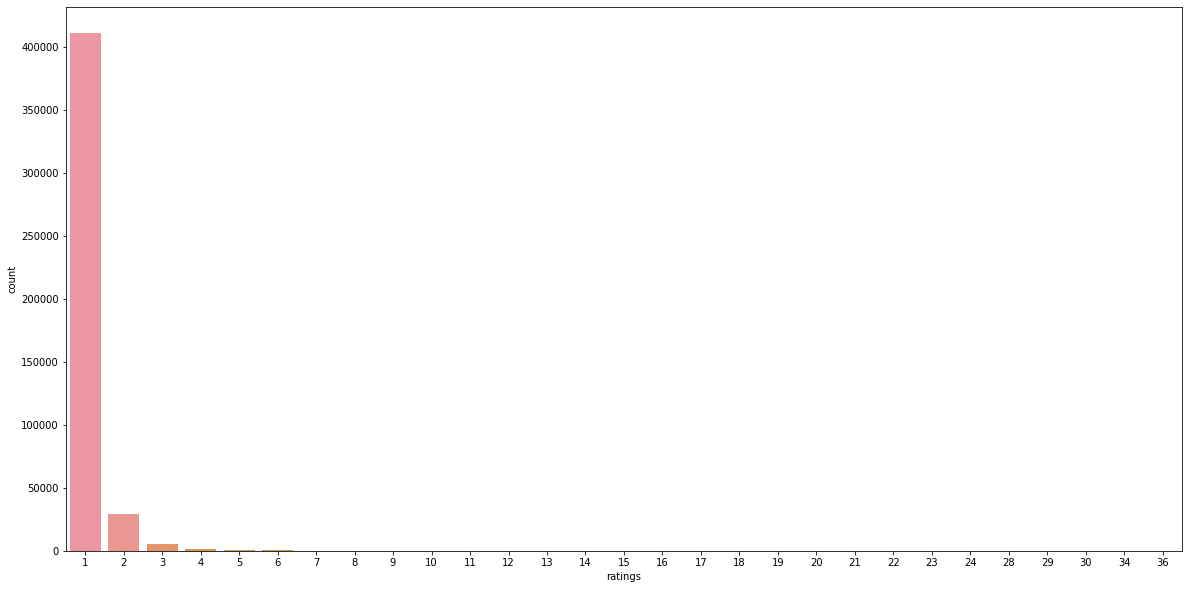

In [16]:
plt.figure(figsize=(20,10))
sns.countplot(x=user_prod['ratings'])

#### *As we can see from the above, an abysmal number of users have only rated 1 item. We can thus use this a filtering method to eliminate such users as these people would have very poor collaboration & preparing a COLLABORATIVE FILTERING BASED MODEL using such data would result in very poor results.*

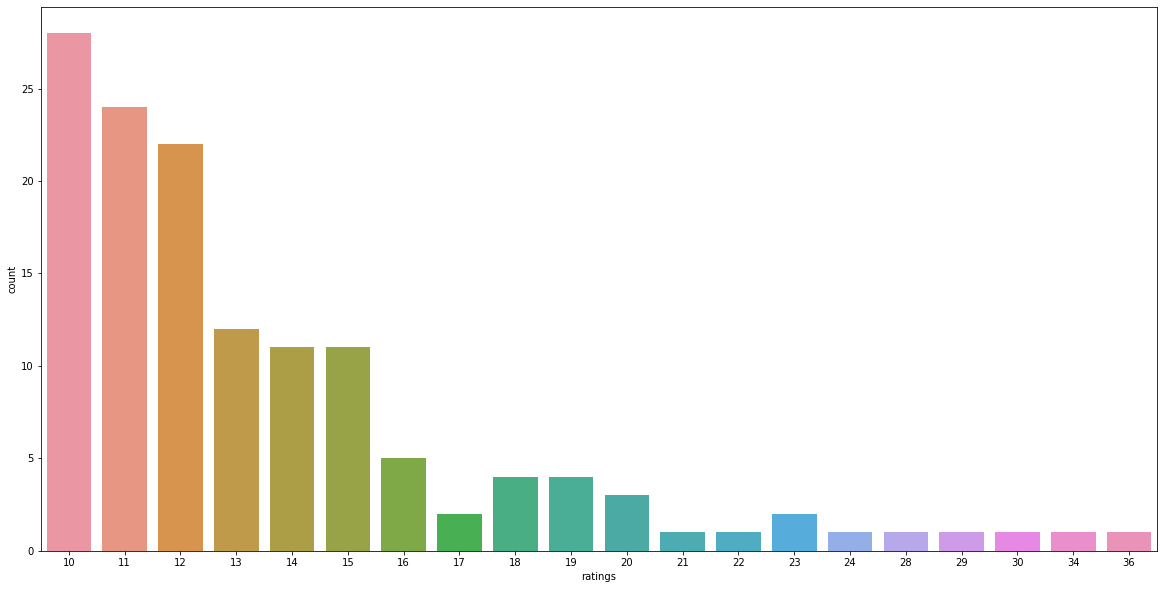

In [17]:
plt.figure(figsize=(20,10))
sns.countplot(x=user_prod[user_prod['ratings']>=10]['ratings'])

#### *Thus there are around 25+ such users who have rated at least 10 items, while there are around roughly 3 users who have rated as many as 36 items. We can proceed with our COLLABORATIVE FILTERING based model building using these users*

In [18]:
#Creating a safe-copy of data before starting with imputations & feature-engineering
data_bkup = data_filtrd.copy()

In [19]:
user_counts = pd.DataFrame(data_filtrd.groupby('user_id')['ratings'].count())
final_users = user_counts[user_counts['ratings']>=10]
final_users.reset_index(inplace=True)
ratings_final = data_filtrd[data_filtrd['user_id'].isin(final_users['user_id'])]
ratings_final.shape

(1875, 3)

In [20]:
ratings_final.head()

,user_id,prod_id,ratings
264,A1YEPFLLH42OU1,B00E3W15P0,5.0
413,A10Y058K7B96C6,B005HSG3VK,5.0
526,A3EZEP0FX5BC1P,B0044DHU84,4.0
719,A17HMM1M7T9PJ1,B00ESKS0KU,4.0
913,A15CL28ALB7MTZ,B001QFYCXO,4.0


#### *Thus we are proceeding with a dataset that has around 1875 datapoints comprising only of those users who have rated at least 10 or more products, and the products they have rated*

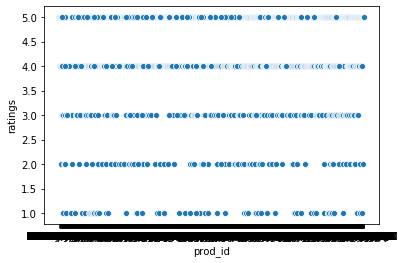

In [21]:
sns.scatterplot(x=ratings_final['prod_id'],y=ratings_final['ratings'])

#### *From the above, we can infer that the distribution of ratings across all sets of items is more or less uniform*

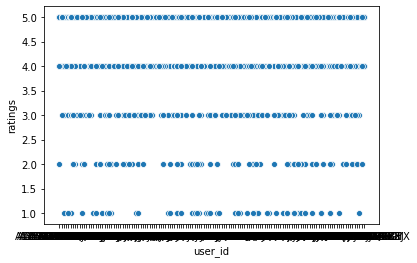

In [22]:
sns.scatterplot(x=ratings_final['user_id'],y=ratings_final['ratings'])

#### *From the above distribution, it seems that most users prefer giving high ratings (4,5), with the distribution of users providing poor ratings (1,2) very sparse, as is the case for average ratings also(3)*

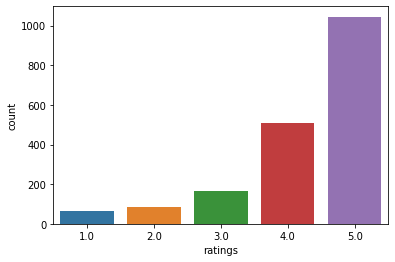

In [23]:
sns.countplot(x=ratings_final['ratings'])

#### *The above count-plot corraborates our earlier findings from the 'userID vs ratings' scatter plot. The rating 5 has the highest population, and cumulatively the ratings 4 & 5 superseed all other ratings*

### 3. Split the data randomly into train and test dataset. ( For example, split it in 70/30 ratio) ( 2 marks)

In [24]:
reader = Reader(rating_scale=(1, 5))
#data = Dataset.load_from_df(data_final,reader)
data = Dataset.load_from_df(ratings_final,reader)
trainset, testset = train_test_split(data, test_size=0.3,random_state=100)

### 4. Build Collaborative Filtering model. ( 10 marks)

In [25]:
# Proceeding with User-Based collaborative filtering
svd_algo = SVD(n_factors=50,biased=False,random_state=100)
svd_algo.fit(trainset)

In [26]:
# run the trained model against the testset
svd_pred = svd_algo.test(testset)

### 5. Evaluate the above model. ( Once the model is trained on the training data, it can be used to compute the error (like RMSE) on predictions made on the test data.) You can also use a different method to evaluate the models. ( 5 marks)

In [27]:
# get RMSE
print("RMSE score for base-line SVD Model for Collaborative Filtering, using 50 factors:")
accuracy.rmse(svd_pred, verbose=True)

RMSE score for base-line SVD Model for Collaborative Filtering, using 50 factors:
RMSE: 1.4974


1.4974420461887237

#### *Since the RMSE score is not very good, let us try to see if we can tinker with the parameters of the model & achieve a better RMSE value. For determining the optimal hyper-parameters, we resort to GridSearchCV, with 10 folds*

In [28]:
param_grid = {'n_factors': [50,100,150],'n_epochs': [20,30], 'lr_all': [0.005,0.01],'reg_all':[0.1,0.01,0.02]}

In [29]:
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=10, n_jobs=10, refit = True)
gs.fit(data)
params = gs.best_params['rmse']

In [30]:
svdtuned = SVD(n_factors=params['n_factors'], n_epochs=params['n_epochs'],lr_all=params['lr_all'], reg_all=params['reg_all'],random_state=100)
svdtuned.fit(trainset)

In [31]:
# run the trained model against the testset
svdtuned_pred = svdtuned.test(testset)

# Check to see if there is any improvement in the RMSE
print("RMSE score for tuned SVD Model for Collaborative Filtering:")
accuracy.rmse(svdtuned_pred, verbose=True)

RMSE score for tuned SVD Model for Collaborative Filtering:
RMSE: 0.9642


0.9642458511680179

#### *Lastly checking if the model improves if we use a different algorithm*

In [32]:
model = KNNWithMeans(k=50, sim_options={'name': 'pearson_baseline', 'user_based': True},random_state=100)
model.fit(trainset)
# run the trained model against the testset
knn_pred = model.test(testset)

print("RMSE score for base-line KNN Model for User-based Collaborative Filtering, using 50 neighbors:")
accuracy.rmse(knn_pred, verbose=True)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE score for base-line KNN Model for User-based Collaborative Filtering, using 50 neighbors:
RMSE: 0.9850


0.9850335681495674

#### *With hyper-parameter tuning, we have achieved a slightly better RMSE & when we used kNNWithMeans algorithm, we obtained a comparable RMSE score*

### 6. Get top - K ( K = 5) recommendations. Since our goal is to recommend new products to each user based on his/her habits, we will recommend 5 new products. ( 10 marks)

In [33]:
testset_new = trainset.build_anti_testset()
predictions = svdtuned.test(testset_new)

In [34]:
predictions_df = pd.DataFrame([[x.uid,x.iid,x.est] for x in predictions])

In [35]:
predictions_df.columns = ["userId","prodId","est_rating"]
predictions_df.sort_values(by = ["userId","prodId","est_rating"],ascending=False,inplace=True)

In [42]:
#showing the top-5 recommendations in general
predictions_df.sort_values(by=['prodId'],ascending=False)['prodId'].head()

65946     B00L2442H0
123451    B00L2442H0
27983     B00L2442H0
152862    B00L2442H0
90414     B00L2442H0
Name: prodId, dtype: object

In [44]:
#Predicting top-5 products for 1 particular user
predictions_df[predictions_df['userId']=='A100WO06OQR8BQ'].head(5)

,userId,prodId,est_rating
32881,A100WO06OQR8BQ,B00L2442H0,3.809644
31899,A100WO06OQR8BQ,B00KMRGB7C,3.816115
31841,A100WO06OQR8BQ,B00KH8PU6E,3.809326
32008,A100WO06OQR8BQ,B00KGTDDIG,3.743381
32151,A100WO06OQR8BQ,B00K6B7KJM,3.831761


#### *The above shows the top-5 recommendations for a given user "A100WO06OQR8BQ" as per the SVD model*

### 7. Summarise your insights. ( 10 marks)

#### *We first devised a POPULARITY BASED recommendation system wherein we are able to predict the top-5 most popular products to any new users. This doesn't require us to have any apriori knowledge of the users*

#### *While we proceeded with the entire dataset while we were designing our POPULARITY BASED MODEL, it didn't make sense to take the entire dataset for our COLLABORATIVE FILTERING MODEL, especially when we saw that a huge number of users had rated only 1 item. This would have caused undue sparsity in our collaboration matrix & we thus filtered down our data to only those users who have rated at least 10 items*

#### *If we filtered our data further, by choosing only such users who have rated say 15 or more items, we could've achieved a better RMSE as our user-item collaboration matrix would be more dense & our model would be thus more accurate*

#### *However, going with only those users who rated at least 10 items, we were able to achieve a RMSE of 1.49 with a plain-vanilla SVD model, and once we tuned the same we were able to bring the RMSE to below 1*

#### *Using this model, we were then able to design a recommendation system which would be able to predict the top-5 products for a given user*